<a href="https://colab.research.google.com/github/Sergey-Kit/RecoServiceTemplate/blob/hw_6/notebooks/itmo_recsys_dz_5_two_stage_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ранжирование в рекомендациях с помощью двухэтапной модели

In [ ]:
!pip install dill shap lightfm rectools[all]

In [ ]:
!pip install -U torch torchvision torchaudio

# Учим модель первого уровня

## Импорты

In [7]:
import gc
import json
from pathlib import Path
from typing import List
import pickle
import warnings
warnings.simplefilter('ignore')

import dill
import numpy as np
import pandas as pd
import requests
import shap

from implicit.als import AlternatingLeastSquares
from rectools.dataset import Dataset
from rectools import Columns
from lightgbm import LGBMRanker, LGBMClassifier
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools.models import ImplicitALSWrapperModel, PopularModel
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Tuple
from tqdm.auto import tqdm
from zipfile import ZipFile

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

## Подготовка данных

In [8]:
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip -O data_KION.zip
!unzip -o data_KION.zip
!rm data_KION.zip

Archive:  data_KION.zip
  inflating: data_original/interactions.csv  
  inflating: __MACOSX/data_original/._interactions.csv  
  inflating: data_original/users.csv  
  inflating: __MACOSX/data_original/._users.csv  
  inflating: data_original/items.csv  
  inflating: __MACOSX/data_original/._items.csv  


In [9]:
%%time
interactions = pd.read_csv('data_original/interactions.csv')
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

CPU times: user 2.87 s, sys: 585 ms, total: 3.46 s
Wall time: 4.51 s


# Preprocess

In [10]:
Columns.Datetime = 'last_watch_dt'

interactions.drop(interactions[interactions[Columns.Datetime].str.len() != 10].index, inplace=True)

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')

max_date = interactions[Columns.Datetime].max()

interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)

train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train.drop(train.query("total_dur < 300").index, inplace=True)

# отфильтруем холодных пользователей из теста
cold_users = set(test[Columns.User]) - set(train[Columns.User])

test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

train: (4985269, 6)
test: (490982, 6)


# Prepare features

In [11]:
def get_user_features(users: pd.DataFrame, interactions: pd.DataFrame, features: List[str]):
    users = users.fillna("Unknown")
    users = users.loc[users[Columns.User].isin(interactions[Columns.User])].copy()
    user_features_frames = []

    for feature in features:
        feature_frame = users.reindex(columns=[Columns.User, feature])
        feature_frame.columns = ["id", "value"]
        feature_frame["feature"] = feature
        user_features_frames.append(feature_frame)

    user_features = pd.concat(user_features_frames)

    return user_features

In [12]:
def get_item_features(items: pd.DataFrame, interactions: pd.DataFrame):
    items = items.loc[items[Columns.Item].isin(interactions[Columns.Item])].copy()
    items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")

    genre_feature = items[["item_id", "genre"]].explode("genre")
    genre_feature.columns = ["id", "value"]
    genre_feature["feature"] = "genre"

    content_feature = items.reindex(columns=[Columns.Item, "content_type"])
    content_feature.columns = ["id", "value"]
    content_feature["feature"] = "content_type"

    item_features = pd.concat((genre_feature, content_feature))

    return item_features

In [13]:
user_features = get_user_features(users, train, ['sex', 'age', 'income'])
item_features = get_item_features(items, train)

In [14]:
%%time
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

CPU times: user 1.09 s, sys: 43.2 ms, total: 1.14 s
Wall time: 1.22 s


In [15]:
RANDOM_STATE = 32
N_EPOCHS = 1

In [ ]:
%%time
model = ImplicitALSWrapperModel(
        model=AlternatingLeastSquares(
            factors=128,
            random_state=RANDOM_STATE,
            num_threads=3,
        ),
        fit_features_together=True,
    )

model.fit(dataset)

In [ ]:
top_N = 50
candidates = model.recommend(dataset.user_id_map.external_ids, dataset, top_N, True)

In [ ]:
candidates = candidates.rename({"rank": "als_rank", "score": "als_score"}, axis=1)
candidates.head()

In [ ]:
candidates.to_csv("als_candidates.csv", index=False)

In [ ]:
with open("ALS.pkl", "wb") as f:
    pickle.dump(model,f)

# Учим ранкер

### `interactions`: взаимодействия пользователь - айтем
- с датой `last_watch_dt`
- длительностью просмотра `total_dur`
- % просмотра `watched_pct`

In [16]:
candidates = pd.read_csv('als_candidates.csv')

In [17]:
interactions = pd.read_csv('data_original/interactions.csv')
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

In [18]:
print(interactions.shape)
interactions.head(3)

(5476251, 5)


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0


In [19]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        "last_watch_dt": Columns.Datetime,
        "watched_pct": Columns.Weight,
    },
    inplace=True,
)


In [20]:
# Меняем тип данных
interactions[Columns.Datetime] = interactions[Columns.Datetime].astype(np.datetime64)

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
    Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.0,
    "total_dur": 0,
}
interactions.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions.head(10)

,user_id,item_id,last_watch_dt,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


In [21]:
interactions.describe(datetime_is_numeric=True)

,user_id,item_id,last_watch_dt,total_dur,weight
count,5.476251e+06,5.476251e+06,5476251,5.476251e+06,5.476251e+06
mean,5.491159e+05,8.485860e+03,2021-06-23 11:56:04.296268032,8.295490e+03,4.636699e+01
min,0.000000e+00,0.000000e+00,2021-03-13 00:00:00,1.000000e+00,0.000000e+00
25%,2.750140e+05,4.326000e+03,2021-05-25 00:00:00,3.710000e+02,4.000000e+00
50%,5.493640e+05,8.776000e+03,2021-07-01 00:00:00,2.898000e+03,3.200000e+01
75%,8.227540e+05,1.254400e+04,2021-07-30 00:00:00,7.116000e+03,1.000000e+02
max,1.097557e+06,1.651800e+04,2021-08-22 00:00:00,8.041167e+07,1.000000e+02
std,3.166077e+05,4.740762e+03,NaN,4.856799e+04,4.191923e+01


### `users`: данные о пользователях

- `age` бин по возрасту
- `income` бин по доходу
- `sex` пол
- `kids_flg` флаг наличия детей

Все признаки - результат предсказания соцдем моделей

In [22]:
print(users.shape)
users.head(3)

(840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0


In [23]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
    # 'user_id',
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding['income'], users['income'].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [24]:
users.head(3)

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0


In [25]:
# Наиболее популярны income - income_40_60
users.describe(include='category')

,age,income,sex,kids_flg
count,840197,840197,840197,840197
unique,7,7,3,2
top,1,2,0,0
freq,233926,471519,425270,587209


### `items`: данные об айтемах

- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное
- `release_year` - год выпуска
- `countries` - страны
- `for_kids` - флаг контент для детей
- `age_rating`- Возрастной рейтинг
- `studios` - студии
- `directors` - режиссеры
- `actors`- актеры
- `keywords` - ключевые слова
- `description` - описание

In [26]:
print(items.shape)
items.head(3)

(15963, 14)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [27]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [
    # 'item_id',
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating',
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols)
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding['studios']

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

In [28]:
items.describe(include='all')

,item_id,content_type,release_year,for_kids,age_rating,studios
count,15963.000000,15963.0,15963.000000,15963.0,15963.000000,15963.0
unique,NaN,2.0,NaN,3.0,NaN,39.0
top,NaN,0.0,NaN,-1.0,NaN,-1.0
freq,NaN,12002.0,NaN,15397.0,NaN,14898.0
mean,8268.453424,NaN,2007.969492,NaN,12.945937,NaN
std,4773.841513,NaN,16.835890,NaN,5.495760,NaN
min,0.000000,NaN,1897.000000,NaN,0.000000,NaN
25%,4141.500000,NaN,2007.000000,NaN,12.000000,NaN
50%,8266.000000,NaN,2014.000000,NaN,16.000000,NaN
75%,12414.500000,NaN,2018.000000,NaN,16.000000,NaN


## Трейн-вал-тест сплит

In [29]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


### Схема валидации с разбиением по юзерам (удобна для первого запуска в  проде)

In [30]:
# Обучать ранжирование будем на последнем месяце (30 дней) не считая отложенной недели
# Лучше зафиксировать временной диапазон если на проде планируется переобучать модель
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

# В дальнейшем ranker_data разбиваем по юзерам
#  на train val test для обучения, валидации и тестирования ранкера
train_size = 0.7
val_size = 0.15
test_size = 0.15

# В train_test_split очень удобно можно сохранить исходное распределение по нужным факторам,
#  задав параметр stratify. Правда мы на это пока забьем)

train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

In [31]:
# Для базовых моделей первого уровня (в нашем случае только lightfm)
#  оставим все оставшиеся взаимодействия для обучения

base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

## Берем кандидатов, полученных из модели 1 уровня

In [32]:
# Считаем метрики
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k = 10),
        'map@10': MAP(k = 10),
        'Precision@10': Precision(k = 10),
        'recall@10': Recall(k = 10),
        'novelty@10': MeanInvUserFreq(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ),
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics['als'] = calc_metrics_(candidates, 'als_rank')
models_metrics['als']

{'Precision@10': 0.002161067026844504,
 'recall@10': 0.003952641277790183,
 'ndcg@10': 0.002678009053922878,
 'map@10': 0.0019626448264762754,
 'novelty@10': 3.843299815756233}

# Модель для холодных юзеров (популярное)


In [33]:
dataset = Dataset.construct(base_models_data)
popular_model = PopularModel()
popular_model.fit(dataset)

n_items = items[Columns.Item].nunique()
pop_candidates = popular_model.recommend(
    dataset.user_id_map.external_ids[:1], dataset, n_items, True
)
pop_candidates.rename({"rank": "popular_rank", "score": "popular_score"}, axis=1, inplace=True)
pop_candidates.drop(Columns.User, axis=1, inplace=True)
pop_candidates.head()

,item_id,popular_score,popular_rank
0,10440,141889.0,1
1,15297,137128.0,2
2,13865,93403.0,3
3,4151,69641.0,4
4,2657,55146.0,5


In [117]:
%%time
candidates = pd.read_csv("/content/drive/MyDrive/als_candidates.csv")

CPU times: user 9.07 s, sys: 5.22 s, total: 14.3 s
Wall time: 17.3 s


In [118]:
pop_candidates = pd.read_csv("/content/drive/MyDrive/pop_candidates.csv")

In [34]:
candidates = candidates.merge(pop_candidates, how="left", on=[Columns.Item])
candidates.head()

,user_id,item_id,als_score,als_rank,popular_score,popular_rank
0,176549,13865,0.420064,1.0,93403.0,3.0
1,176549,10440,0.413222,2.0,141889.0,1.0
2,176549,15297,0.367386,3.0,137128.0,2.0
3,176549,3734,0.284114,4.0,50004.0,6.0
4,176549,4151,0.262605,5.0,69641.0,4.0


In [35]:
gc.collect()

1827

In [35]:
candidates.to_csv("/content/drive/MyDrive/candidates.csv", index=False)

In [36]:
calc_metrics_(candidates, "popular_rank")

{'Precision@10': 0.0014442926649578685,
 'recall@10': 0.002510476707078506,
 'ndcg@10': 0.001712076377515659,
 'map@10': 0.0010670083255508135,
 'novelty@10': 3.1197793299302146}

# Формируем датасет для ранкера

## Генерим фичи для ранкера

In [37]:
# Получаем длину истории юзера
base_models_data["user_hist"] = base_models_data.groupby("user_id")["item_id"].transform("count")
# Получаем популярность контента
base_models_data["item_pop"] = base_models_data.groupby("item_id")["user_id"].transform("count")
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data["user_avg_pop"] = base_models_data.groupby("user_id")["item_pop"].transform("mean")
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data["item_avg_hist"] = base_models_data.groupby("item_id")["user_hist"].transform(
    "mean"
)
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime],
    ascending=[True, False],
    ignore_index=True,
    inplace=True,
)
base_models_data["user_last_pop"] = base_models_data.groupby("user_id")["item_pop"].transform(
    "first"
)
# фича для определения насмотренности юзера
base_models_data["whole_watched"] = base_models_data["total_dur"] * base_models_data["weight"] / 100
base_models_data["user_watch_time"] = base_models_data.groupby("user_id")["whole_watched"].transform("sum")
base_models_data.drop("whole_watched", axis=1, inplace=True)

base_models_data.head(3)

,user_id,item_id,last_watch_dt,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop,user_watch_time
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208,7.67
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208,7.67
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208,7.67


In [38]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items,
    right=(base_models_data[["item_id", "item_pop", "item_avg_hist"]].drop_duplicates()),
    how="left",
    on="item_id",
)

users = pd.merge(
    left=users,
    right=(
        base_models_data[
            ["user_id", "user_hist", "user_avg_pop", "user_last_pop", "user_watch_time"]
        ].drop_duplicates()
    ),
    how="left",
    on="user_id",
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop,user_watch_time
0,973171,1,4,1,1,5.0,19550.800000,93403.0,171398.16
1,962099,0,2,1,0,13.0,1329.307692,260.0,58671.26
2,1047345,3,3,0,0,NaN,NaN,NaN,NaN


In [39]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно,
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
default_values_items["item_pop"] = base_models_data["item_pop"].median()
default_values_items["item_avg_hist"] = base_models_data["item_avg_hist"].median()

# Для новых фичей юзеров
default_values_users = {
    "user_hist": 0,
    "user_avg_pop": base_models_data["user_avg_pop"].median(),
    "user_last_pop": base_models_data["user_last_pop"].median(),
    "user_watch_time": 0,
}

### Джойним кандидатов и юзер/айтем фичи

In [40]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомы и таргеты


def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df["user_id"].isin(user_list)],
        candidates_df[candidates_df["user_id"].isin(user_list)],
        how="right",
        on=["user_id", "item_id"],
    )
    # Проставляем дефолтные значения интеракций
    lfm_min_score: float = df["als_score"].min() - 0.01
    lfm_max_rank: int = df["als_rank"].max() + 1  # 51
    pop_min_score: float = df["popular_score"].min() - 0.01
    pop_max_rank: int = df["popular_rank"].max() + 1  # 51

    default_values = {
        "als_score": lfm_min_score,
        "als_rank": lfm_max_rank,
        "popular_score": pop_min_score,
        "popular_rank": pop_max_rank,
        # Важно использовате те же дефолтные значения для интеракций,
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)

    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    return df


ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,last_watch_dt,total_dur,weight,als_score,als_rank,popular_score,popular_rank
1267339,3,657,2021-07-01,0.0,0.0,0.054857,40.0,7157.00,48.0
1267323,3,1132,2021-07-01,0.0,0.0,0.086339,24.0,0.99,14941.0
1267324,3,1449,2021-07-01,0.0,0.0,0.081622,25.0,7887.00,37.0


In [42]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(df, users, how="left", on=["user_id"])
    df = pd.merge(df, items, how="left", on=["item_id"])

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df


# Не забываем добавить фичи в трейн, вал и тест
# Еще правильнее бы было сначала подготовить датасет,
# а потом его разбивать по юзерам - так бы мы избежали дублирования операций.
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,last_watch_dt,total_dur,weight,als_score,als_rank,popular_score,popular_rank,age,...,user_avg_pop,user_last_pop,user_watch_time,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,657,2021-07-01,0.0,0.0,0.054857,40.0,7157.00,48.0,-1,...,11957.864865,2858.0,0.0,0,2015.0,-1,18.0,-1,7157.0,23.835266
1,3,1132,2021-07-01,0.0,0.0,0.086339,24.0,0.99,14941.0,-1,...,11957.864865,2858.0,0.0,0,2020.0,-1,16.0,-1,9638.0,20.171612
2,3,1449,2021-07-01,0.0,0.0,0.081622,25.0,7887.00,37.0,-1,...,11957.864865,2858.0,0.0,1,2012.0,-1,16.0,-1,7887.0,17.005579


In [ ]:
del candidates
gc.collect()

In [46]:
# Датасеты готовы, остались только таргеты,
# которые можно посчитать на основе колонок total_dur и watched_pct

# Делаем еще один чекпоинт.
for name in ["train", "val", "test"]:
    path: str = f"/content/drive/MyDrive/ranker_{name}.csv"
    locals()[f"ranker_{name}"].to_csv(path, index=False)

# Обучаем ранкер

## Pointwise

In [83]:
# Загружаем данные
for name in ["train", "val", "test"]:
    path: str = f"/content/drive/MyDrive/ranker_{name}.csv"
    locals()[f"ranker_{name}"] = pd.read_csv(path)

In [84]:
# таргет бинарный, так что -
# будем считать просмотр хорошим если доля досмотра больше половины


def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df["target"] = df[Columns.Weight] > 50  # 'watched_pct'
    df["target"] = df["target"].astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,last_watch_dt,total_dur,weight,als_score,als_rank,popular_score,popular_rank,age,...,user_last_pop,user_watch_time,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target
0,3,657,2021-07-01,0.0,0.0,0.054857,40.0,7157.00,48.0,-1,...,2858.0,0.0,0,2015.0,-1,18.0,-1,7157.0,23.835266,0
1,3,1132,2021-07-01,0.0,0.0,0.086339,24.0,0.99,14941.0,-1,...,2858.0,0.0,0,2020.0,-1,16.0,-1,9638.0,20.171612,0
2,3,1449,2021-07-01,0.0,0.0,0.081622,25.0,7887.00,37.0,-1,...,2858.0,0.0,1,2012.0,-1,16.0,-1,7887.0,17.005579,0


In [85]:
# В train и val можно удалить 'плохих' пользователей,
# Например тех у кого слишком много или мало просмотров или
# тех для которых нет достаточного количества рекомендаций от LightFM
# Тестовую группу не меняем


def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    groups_df = (
        df[["user_id", "item_id"]]
        .groupby(by=["user_id"])
        .count()
        .rename(columns={"item_id": "group_size"})
    )
    df = pd.merge(df, groups_df, how="left", on=["user_id"])
    # Удаляем группы, без достаточного числа просмотров/кандидатов
    df = df[df["group_size"] >= 50]

    # Колонка больше не нужна
    df.drop(columns=["group_size"], inplace=True)
    return df


def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["als_rank"] <= 50]


ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)

ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)
ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)
# ranker_test = filter_group(ranker_test)

In [86]:
# Вспоминаем какие есть колонки
ranker_train.columns

Index(['user_id', 'item_id', 'last_watch_dt', 'total_dur', 'weight',
       'als_score', 'als_rank', 'popular_score', 'popular_rank', 'age',
       'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop',
       'user_last_pop', 'user_watch_time', 'content_type', 'release_year',
       'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist',
       'target'],
      dtype='object')

In [87]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    "als_score",
    "als_rank",
    "popular_score",
    "popular_rank",
    "age",
    "income",
    "sex",
    "kids_flg",
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    "user_watch_time",
    "content_type",
    "release_year",
    "for_kids",
    "age_rating",
    "studios",
    "item_pop",
    "item_avg_hist",
]
# Из них категориальные:
cat_cols = [
    "age",
    "income",
    "sex",
    "kids_flg",
    "content_type",
    "for_kids",
    "studios",
]

In [88]:
early_stopping_rounds = 32

params = {
    "objective": "binary",
    "n_estimators": 10000,  # максимальное число деревьев
    "max_depth": 4,  # максимальная глубина дерева
    "num_leaves": 10,  # число листьев << 2^max_depth
    "min_child_samples": 100,  # число примеров в листе
    "learning_rate": 0.25,  # шаг обучения
    "reg_lambda": 1,  # L2 регуляризация
    "colsample_bytree": 0.9,  # доля колонок, которая используется в каждом дереве
    "early_stopping_rounds": early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    "verbose": early_stopping_rounds // 8,  # период вывода метрик
    "random_state": 42,
}
fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target"],
    "eval_set": [(ranker_val[cols], ranker_val["target"])],
    "eval_metric": "logloss",
    "categorical_feature": cat_cols,
    "feature_name": cols,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 4359, number of negative: 1523341
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.907998
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.239564
[LightGBM] [Debug] init for col-wise cost 0.021484 seconds, init for row-wise cost 0.143946 seconds
[LightGBM

LGBMClassifier(colsample_bytree=0.9, early_stopping_rounds=32,
               learning_rate=0.25, max_depth=4, min_child_samples=100,
               n_estimators=10000, num_leaves=10, objective='binary',
               random_state=42, reg_lambda=1, verbose=4)

In [89]:
# Смотрим на логлосс на валидации
pointwise_model.best_score_["valid_0"]["binary_logloss"]

0.017494738641391318

In [90]:
# SHAP - values
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

# lightGBM returns probabilities for both classes and I have to modify the SHAP values as
shap_values.values = shap_values.values[:, :, 1]
shap_values.base_values = shap_values.base_values[:, 1]

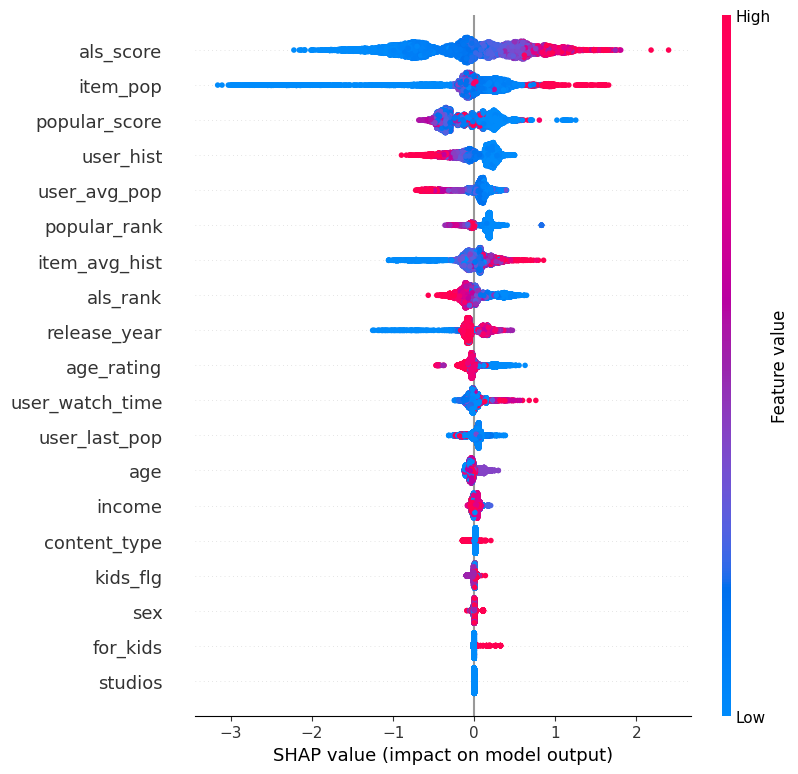

In [91]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

Модель наибольшее значение придает признаку als_score.

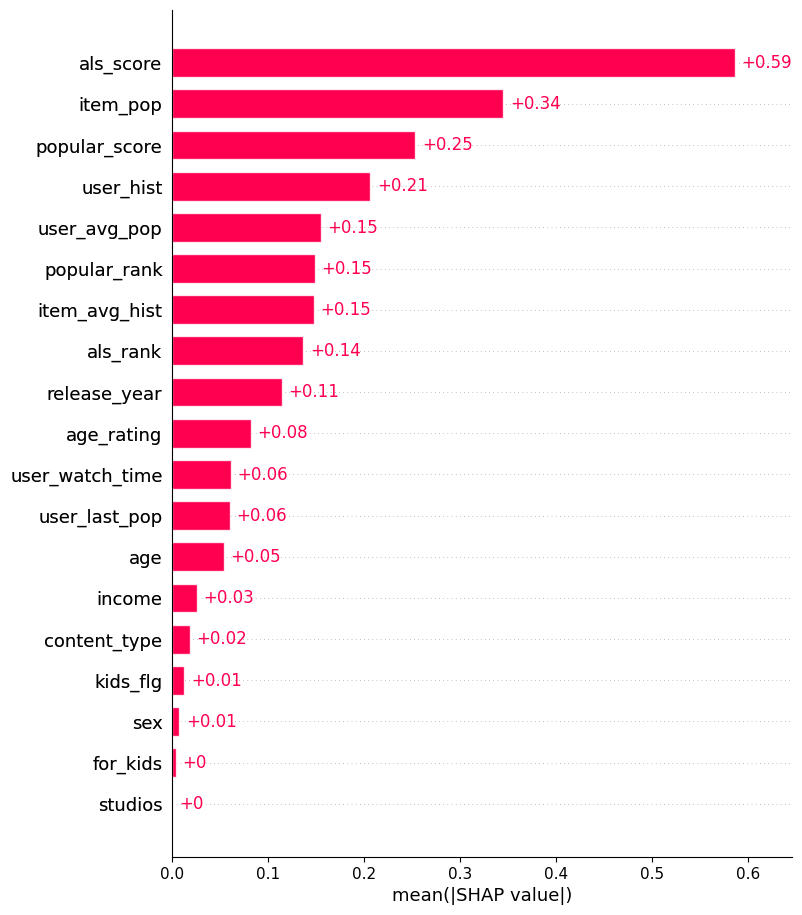

In [92]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [93]:
# Получаем предсказания для тестовых юзеров
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
y_true: np.ndarray = np.array(ranker_test["target"])

y_pred

array([0.00035227, 0.00040728, 0.00085986, ..., 0.00065937, 0.00073989,
       0.00116493])

In [94]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f"{name}_score"] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=["user_id", f"{name}_score"],
        ascending=[True, False],
        inplace=True,
    )
    df[f"{name}_rank"] = df.groupby("user_id").cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = (df["als_rank"] < 50).to_numpy()
    # Добавляем общий скор двухэтапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f"{name}_hybrid_score"] = df[f"{name}_score"] * mask
    df[f"{name}_hybrid_score"].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двухэтапной модели
    df[f"{name}_hybrid_rank"] = df[f"{name}_rank"] * mask
    max_rank: int = 50
    df[f"{name}_hybrid_rank"].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [95]:
ranker_test = add_score_and_rank(ranker_test, y_pred, "pointwise")
ranker_test.head(3)

,user_id,item_id,last_watch_dt,total_dur,weight,als_score,als_rank,popular_score,popular_rank,age,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank
31,53,9728,2021-07-01,0.0,0.0,0.767099,1.0,0.99,14908.0,3,...,-1,18.0,-1,76978.0,11.165736,0,0.015577,1,0.015577,1
26,53,7793,2021-07-01,0.0,0.0,0.102212,26.0,84.00,3459.0,3,...,-1,16.0,-1,84.0,36.607143,0,0.005059,2,0.005059,2
22,53,7102,2021-07-01,0.0,0.0,0.192809,13.0,0.99,14908.0,3,...,-1,18.0,-1,11626.0,20.349475,0,0.003564,3,0.003564,3


In [96]:
# Считаем рок аук от sklearn (не усредненный по юзерам)
roc_auc_score(y_true, y_pred)  # Получилась ерунда

0.8177652295724509

In [97]:
# Получим значения метрик
models_metrics["lfm"] = calc_metrics_(ranker_test, "als_rank")
models_metrics["pointwise"] = calc_metrics_(ranker_test, "pointwise_rank")
models_metrics["pointwise_hybrid"] = calc_metrics_(ranker_test, "pointwise_hybrid_rank")

pd.DataFrame(models_metrics)[["lfm", "pointwise", "pointwise_hybrid"]]

,lfm,pointwise,pointwise_hybrid
Precision@10,0.002161,0.002488,0.002486
recall@10,0.003953,0.004588,0.004588
ndcg@10,0.002678,0.002980,0.002979
map@10,0.001963,0.002173,0.002173
novelty@10,3.843300,5.163851,5.158295


Метрики стали лучше чем метрики ALS

## Pairwise/Listwise

In [98]:
# Для обучения ранжированию нужно правильно сформировать группы.
# В нашем случае группа равна одному юзеру.
# Для LGBMRanker нужно задать отсортированный по юзерам (группам) датафрейм,
# для которого списком групп будет список из количества
# ранжируемых айтемов на каждого юзера (группу).


def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(df[["user_id", "item_id"]].groupby(by=["user_id"]).count()["item_id"])

In [99]:
# Добавим таргет посложнее


def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df["target_ranker"] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df["target_ranker"] += (df[Columns.Weight] >= 75).astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,last_watch_dt,total_dur,weight,als_score,als_rank,popular_score,popular_rank,age,...,user_watch_time,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target,target_ranker
0,3,657,2021-07-01,0.0,0.0,0.054857,40.0,7157.00,48.0,-1,...,0.0,0,2015.0,-1,18.0,-1,7157.0,23.835266,0,0
1,3,1132,2021-07-01,0.0,0.0,0.086339,24.0,0.99,14941.0,-1,...,0.0,0,2020.0,-1,16.0,-1,9638.0,20.171612,0,0
2,3,1449,2021-07-01,0.0,0.0,0.081622,25.0,7887.00,37.0,-1,...,0.0,1,2012.0,-1,16.0,-1,7887.0,17.005579,0,0


In [100]:
early_stopping_rounds = 32
params = {
    "objective": "lambdarank",  # lambdarank, оптимизирующий ndcg
    "n_estimators": 10000,  # максимальное число деревьев
    "max_depth": 4,  # максимальная глубина дерева
    "num_leaves": 10,  # число листьев << 2^max_depth
    "min_child_samples": 100,  # число примеров в листе
    "learning_rate": 0.25,  # шаг обучения
    "reg_lambda": 1,  # L2 регуляризация
    "colsample_bytree": 0.9,  # доля колонок, которая используется в каждом дереве
    "early_stopping_rounds": early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    "verbose": early_stopping_rounds // 8,  # период вывода метрик
    "random_state": 42,
}
fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target_ranker"],
    "group": get_group(ranker_train),
    "eval_set": [(ranker_val[cols], ranker_val["target_ranker"])],
    "eval_group": [get_group(ranker_val)],
    "eval_metric": "ndcg",
    "eval_at": (3, 5, 10),
    "categorical_feature": cat_cols,
    "feature_name": cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.907998
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.239564
[LightGBM] [Debug] init for col-wise cost 0.021953 seconds, init for row-wise cost 0.150440 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.25,
           max_depth=4, min_child_samples=100, n_estimators=10000,
           num_leaves=10, objective='lambdarank', random_state=42, reg_lambda=1,
           verbose=4)

In [101]:
listwise_model.best_score_["valid_0"]

OrderedDict([('ndcg@3', 0.8830749389273959),
             ('ndcg@5', 0.8913012969712253),
             ('ndcg@10', 0.8999299646822695)])

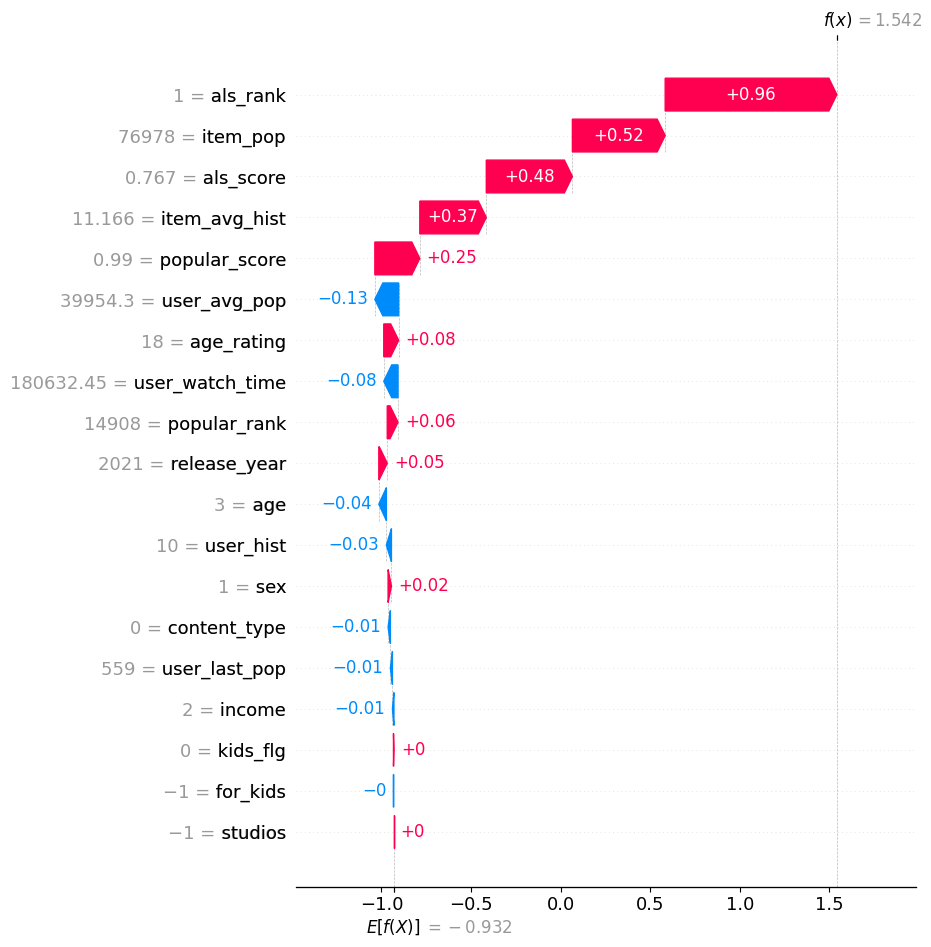

In [102]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

Als_rank вносит наибольший вклад

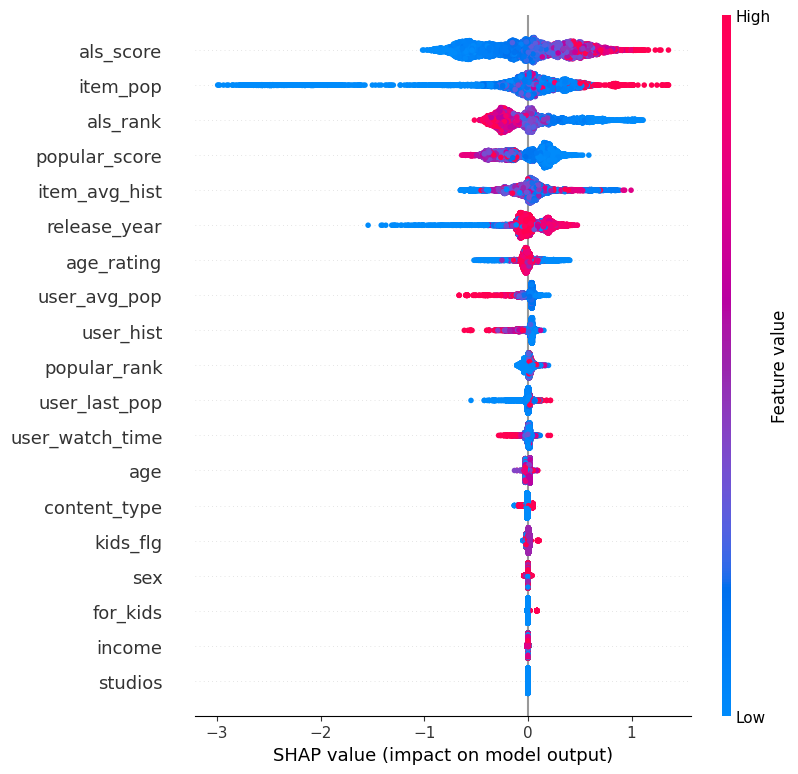

In [103]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

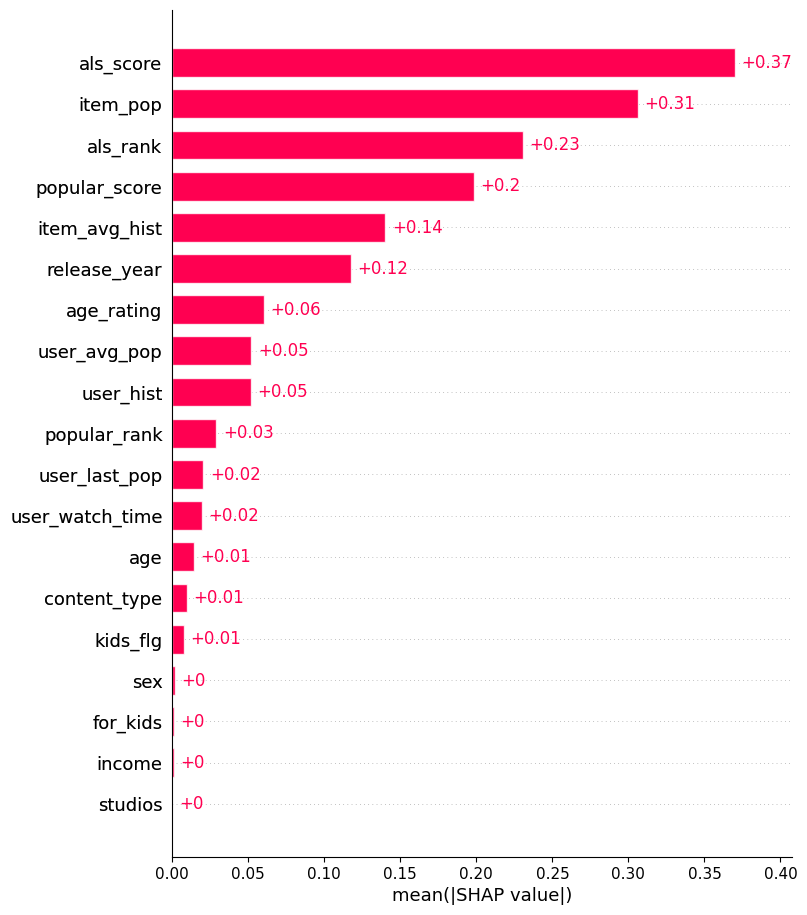

In [105]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [106]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, "listwise")
ranker_test.head(3)

,user_id,item_id,last_watch_dt,total_dur,weight,als_score,als_rank,popular_score,popular_rank,age,...,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
38,53,12192,2021-07-01,0.0,0.0,0.189027,14.0,14317.00,23.0,3,...,0,0.003174,5,0.003174,5,0,1.828891,1,1.828891,1
31,53,9728,2021-07-01,0.0,0.0,0.767099,1.0,0.99,14908.0,3,...,0,0.015577,1,0.015577,1,0,1.541941,2,1.541941,2
26,53,7793,2021-07-01,0.0,0.0,0.102212,26.0,84.00,3459.0,3,...,0,0.005059,2,0.005059,2,0,0.763682,3,0.763682,3


In [107]:
models_metrics["listwise"] = calc_metrics_(ranker_test, "listwise_rank")
models_metrics["listwise_hybrid"] = calc_metrics_(ranker_test, "listwise_hybrid_rank")
pd.DataFrame(models_metrics)[["listwise", "listwise_hybrid"]]

,listwise,listwise_hybrid
Precision@10,0.002661,0.002661
recall@10,0.004961,0.004961
ndcg@10,0.003268,0.003268
map@10,0.002441,0.002441
novelty@10,5.370190,5.366396


## Итоговые метрики

In [108]:
pd.DataFrame(models_metrics)[["als", "pointwise_hybrid", "listwise_hybrid"]]

,als,pointwise_hybrid,listwise_hybrid
Precision@10,0.002161,0.002486,0.002661
recall@10,0.003953,0.004588,0.004961
ndcg@10,0.002678,0.002979,0.003268
map@10,0.001963,0.002173,0.002441
novelty@10,3.843300,5.158295,5.366396


Listwise-ранкер - лучший.

In [72]:
path = "/content/drive/MyDrive/listwise_hybrid.pkl"

with open(path, "wb") as f:
    pickle.dump(listwise_model, f)

# Сохраняем рекомендации для сервиса

In [73]:
for name in ["train", "val", "test"]:
    path: str = f"/content/drive/MyDrive/ranker_{name}.csv"
    locals()[f"ranker_{name}"] = pd.read_csv(path)

In [109]:
ranker_full = pd.concat([ranker_train, ranker_val, ranker_test])
len(ranker_full)

2181450

In [76]:
# Загружаем ранкер
listwise_model = pickle.load(open("/content/drive/MyDrive/listwise_hybrid.pkl", "rb"))

In [110]:
y_pred: np.ndarray = listwise_model.predict(ranker_full[cols])
ranker_full = add_score_and_rank(ranker_full, y_pred, "listwise")
ranker_full.head()

,user_id,item_id,last_watch_dt,total_dur,weight,als_score,als_rank,popular_score,popular_rank,age,...,target,target_ranker,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
46,3,15297,2021-07-01,0.0,0.0,1.148049,1.0,137128.00,2.0,-1,...,0,0,NaN,NaN,NaN,NaN,2.448481,1,2.448481,1
40,3,13865,2021-07-01,0.0,0.0,0.682544,2.0,93403.00,3.0,-1,...,0,0,NaN,NaN,NaN,NaN,0.852656,2,0.852656,2
15,3,6382,2021-07-01,0.0,0.0,0.054895,39.0,2723.00,171.0,-1,...,0,0,NaN,NaN,NaN,NaN,0.401408,3,0.401408,3
20,3,7102,2021-07-01,0.0,0.0,0.126061,13.0,0.99,14941.0,-1,...,0,0,NaN,NaN,NaN,NaN,0.357975,4,0.357975,4
27,3,8636,2021-07-01,0.0,0.0,0.241412,5.0,28660.00,11.0,-1,...,0,0,NaN,NaN,NaN,NaN,0.273779,5,0.273779,5


In [111]:
K_RECS = 10
ranker_full = ranker_full[[Columns.User, Columns.Item, "listwise_hybrid_rank"]]

ranker_full = (
    ranker_full.sort_values([Columns.User, "listwise_hybrid_rank"])
    .groupby(Columns.User)
    .head(K_RECS)
)
ranker_full.drop("listwise_hybrid_rank", axis=1, inplace=True)
ranker_full.head()

,user_id,item_id
46,3,15297
40,3,13865
15,3,6382
20,3,7102
27,3,8636


In [115]:
recommendations_dict = ranker_full.groupby(Columns.User).agg(list).to_dict()[Columns.Item]

In [116]:
with open("/content/drive/MyDrive/two_step_model.pkl", "wb") as f:
    pickle.dump(recommendations_dict, f)